# How to include trapping in Fuel Cycle modelling?

This notebook highlights the importance of adding trapping into the fuel cycle modelling.
We're using our python-based, homemade tool for simulating the evolution of the tritium inventory in the different components of the cycles.

**This is the cycle we will simulate:**

![image](https://user-images.githubusercontent.com/40028739/202560907-a405ae89-44e4-4de0-a08a-bc181948fbe0.png)

To account for trapping in the Outer Fuel Cycle (OFC), the idea is to add another virtual component connected to it:

![image](https://user-images.githubusercontent.com/40028739/202563013-84e8faa3-486c-4806-9e85-fe4a64ef7590.png)

The trapping and detrapping rates are based on McNabb & Foster model.

We will just put some dummy values for the sake of simplicity.

In [2]:
import system_code as tsc
import matplotlib.pyplot as plt
import matplotx
import numpy as np

# some cycle parameters
startup_inventory = 10
storage_volume = 1
n_dot = 1
TBR = 1.2

# trapping properties
trapping_rate = 1
detrapping_rate = 0.1
trap_density = 5

stepsize = 0.2

def run_system(trapping: bool, t_final=20):

    storage = tsc.Box("Storage", outputs={"Plasma": 0.45}, volume=storage_volume, initial_concentration=startup_inventory/storage_volume)

    plasma = tsc.Box("Plasma", outputs={"IFC": 3}, volume=1, generation_term=-n_dot, initial_concentration=1)

    ofc = tsc.Box("OFC", outputs={"IFC": 1}, volume=1, generation_term=n_dot*TBR)
    ifc = tsc.Box("IFC", outputs={"Storage": 1}, volume=1, initial_concentration=0)

    if not trapping:
        my_system = tsc.System([storage, plasma, ifc, ofc], dt=stepsize)

        my_system.run(t_final)

    else:
        # system with trapping in OFC

        ofc_t = tsc.Box("OFC_T", outputs={"OFC": 1}, volume=1)
        ofc.outputs["OFC_T"] = 1
        my_system = tsc.System([storage, plasma, ifc, ofc, ofc_t], dt=stepsize)

        while my_system.current_time < t_final:
            if callable(trapping_rate):
                trapping_rate_current = trapping_rate(my_system.current_time)
            else:
                trapping_rate_current = trapping_rate
            if callable(detrapping_rate):
                detrapping_rate_current = detrapping_rate(my_system.current_time)
            else:
                detrapping_rate_current = detrapping_rate
            # TODO be careful with conservation of mass and all
            gamma_ofc_to_ofct = ofc_t.volume*trapping_rate_current*(trap_density-ofc_t.concentration)
            gamma_ofct_to_ofc = ofc_t.volume*detrapping_rate_current*ofc_t.concentration
            ofc_t.outputs["OFC"] = gamma_ofct_to_ofc
            ofc.outputs["OFC_T"] = gamma_ofc_to_ofct

            my_system.advance()
    
    return my_system

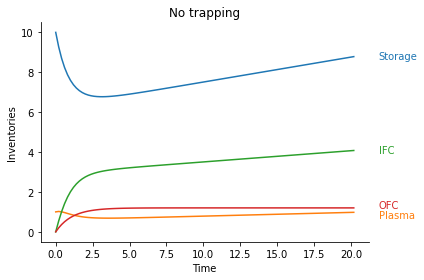

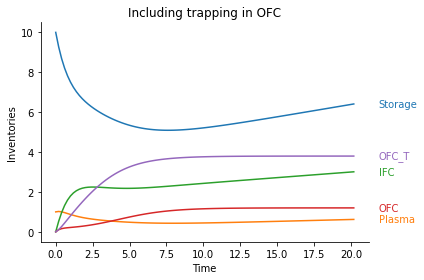

In [3]:
for trapping in [False, True]:
    my_system = run_system(trapping)

    # plot
    plt.figure()
    if trapping:
        plt.title("Including trapping in OFC")
    else:
        plt.title("No trapping")

    for box in my_system.boxes:
        plt.plot(my_system.t, np.array(box.concentrations)*box.volume, label=box.name)
    matplotx.line_labels()
    plt.xlabel("Time")
    plt.ylabel("Inventories")
    plt.tight_layout()
    plt.gca().spines.right.set_visible(False)
    plt.gca().spines.top.set_visible(False)

    if trapping:
        filename = "inventories_standard_trapping.svg"
    else:
        filename = "inventories_standard_no_trapping.svg"
    plt.savefig(filename)

Let's see how the storage inventory behaves when we increase the trap density $n$.

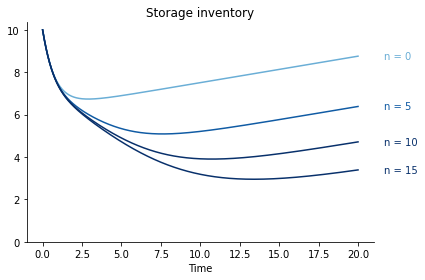

In [6]:
from matplotlib import cm

for trap_density in [0, 5, 10, 15]:
    my_system = run_system(trapping=True)
    for box in my_system.boxes:
        if box.name == "Storage":
            storage = box
            break

    plt.plot(my_system.t, np.array(storage.concentrations)*storage.volume, label=f"n = {trap_density}", color=cm.Blues(trap_density/15+0.5))

plt.title("Storage inventory")
plt.xlabel("Time")
plt.ylim(bottom=0)
matplotx.line_labels()
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.tight_layout()
plt.savefig("influence_of_trap_density_on_storage_inventory.svg")


For a given startup inventory, as the trap density increases, the inflexion time increases and the reserve inventory decreases.

## Simulating baking
With this model, we can simulate things like baking where the temperature of a component is increased to recover the trapped tritium content. Here, this is done by artificially modifying the trapping and detrapping rate after $t=20$.

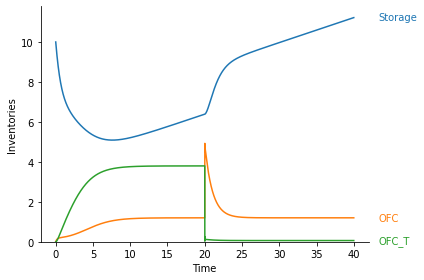

In [7]:
trap_density = 5
stepsize = 0.01

def trapping_rate(t):
    if t < 20:
        return 1
    else:
        return 2

def detrapping_rate(t):
    if t < 20:
        return 0.1
    else:
        return 3000
    
my_system = run_system(trapping=True, t_final=40)

for box in my_system.boxes:
    if box.name in ["Storage", "OFC", "OFC_T"]:
        plt.plot(my_system.t, np.array(box.concentrations)*box.volume, label=box.name)
matplotx.line_labels()
plt.ylim(bottom=0)
plt.xlabel("Time")
plt.ylabel("Inventories")
plt.tight_layout()
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.savefig("inventories_with_baking_phase.svg")

What we observe is that the trapped inventory in the OFC drops and becomes mobile. After a while, this mobile content circulates and reaches the storage component.